# Маркетинг

## Цель и задачи

**Цель:** предсказать вероятность покупки в течение 90 дней.

**Задачи:**
- провести загрузку и предобработку данных;
- провести исследовательский анализ данных;
- разработать синтетические признаки;
- построить различные модели прогнозирования совершения покупки;
- выбрать лучшую модель (целевая метрика - ROC AUC);
- провести анализ результатов работы лучшей модели.

## Описание данных

Датасет **apparel-purchases**:
- client_id - идентификатор клиента;
- quantity - количество единиц товара;
- price - цена товара;
- category_ids - идентификаторы категорий;
- date - дата покупки;
- message_id - идентификатор сообщения из рассылки.

Датасет **apparel-messages**:
- bulk_campaign_id - идентификатор рассылки;
- client_id - идентификатор клиента;
- message_id - идентификатор сообщения;
- event - действие с сообщением (отправлено, открыто, покупка и т.д.);
- channel - канал рассылки;
- date - дата действия;
- created_at - дата-время полностью.

Датасет **full_campaign_daily_event**:
- date - дата;
- bulk_campaign_id - идентификатор рассылки;
- count_event - общее количество каждого события event;
- nunique_event - количество уникальных client_id в каждом событии.

Датасет **full_campaign_daily_event_channel**:
- date - дата;
- bulk_campaign_id - идентификатор рассылки;
- count_event*_channel* - общее количество каждого события по каналам;
- nunique_event*_channel* - количество уникальных client_id по событиям и каналам.

Датасет **apparel-target**:
- client_id - идентификатор клиента;
- target - клиент совершил покупку в целевом периоде.

## Импорт библиотек

In [1]:
!pip install --upgrade matplotlib
!pip install --upgrade seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [2]:
import requests
import urllib
import json
from IPython.display import Markdown, display

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    f1_score,
    ConfusionMatrixDisplay
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

import phik
import shap

In [3]:
RANDOM_STATE = 42

## Загрузка данных

In [4]:
folder_url = 'https://yadi.sk/d/cIfdQTAPMQ8XxA'

files = {}
files['apparel-purchases'] = 'filtered_data/apparel-purchases.csv'
files['apparel-messages'] = 'filtered_data/apparel-messages.csv'
files['apparel-target_binary'] = 'filtered_data/apparel-target_binary.csv'
files['full_campaign_daily_event'] = 'filtered_data/full_campaign_daily_event.csv'
files['full_campaign_daily_event_channel'] = 'filtered_data/full_campaign_daily_event_channel.csv'

df = {}

for file in files:
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + \
          '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + \
          urllib.parse.quote(files[file])
    request = requests.get(url)
    download_url = json.loads(request.text)['href']
    if file=='apparel-target_binary':
        df[file] = pd.read_csv(download_url)
    else:
        df[file] = pd.read_csv(download_url, parse_dates=['date'])

Оптимизируем занимаемую датафреймами память.

In [5]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                        .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [6]:
for d in df:
    print('Датасет:', d)
    df[d] = optimize_memory_usage(df[d])
    print()

Датасет: apparel-purchases
Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)

Датасет: apparel-messages
Размер использования памяти: до 680.38 Mb - после 607.48 Mb (10.7%)

Датасет: apparel-target_binary
Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)

Датасет: full_campaign_daily_event
Размер использования памяти: до 24.00 Mb - после  9.50 Mb (60.4%)

Датасет: full_campaign_daily_event_channel
Размер использования памяти: до 36.00 Mb - после 14.50 Mb (59.7%)



## Обзор данных

Определим функцию для обзора датафрейма.

In [7]:
def quick_profile(df):
    df_ = pd.DataFrame()
    df_['column'] = df.columns
    df_['type'] = list(df.dtypes)
    df_['count'] = list(df.count())
    df_['missing'] = list(df.isna().apply(lambda x: f'{x.sum()} / {x.mean()*100:.2f}%'))
    df_['duplicated'] = f'{df.duplicated().sum()} / {df.duplicated().mean()*100:.2f}%'
    nun = df.select_dtypes(exclude='number').nunique().reindex(df.columns)
    df_['nunique'] = list(map(lambda x: f'{int(x)} / {int(x)/len(df)*100:.2f}%' if x>0 else 'n/a', nun))
    return df_

Определим функцию для вывода данных в режиме Markdown.

In [8]:
def printmd(string):
    display(Markdown(string))

Выведем информацию о загруженных датафреймах.

In [9]:
for d in df:
    printmd('**Датафрейм: '+d+'**')
    display(quick_profile(df[d]))
    printmd('***')

**Датафрейм: apparel-purchases**

,column,type,count,missing,duplicated,nunique
0,client_id,int64,202208,0 / 0.00%,73020 / 36.11%,n/a
1,quantity,int8,202208,0 / 0.00%,73020 / 36.11%,n/a
2,price,float32,202208,0 / 0.00%,73020 / 36.11%,n/a
3,category_ids,object,202208,0 / 0.00%,73020 / 36.11%,933 / 0.46%
4,date,datetime64[ns],202208,0 / 0.00%,73020 / 36.11%,642 / 0.32%
5,message_id,object,202208,0 / 0.00%,73020 / 36.11%,50204 / 24.83%


***

**Датафрейм: apparel-messages**

,column,type,count,missing,duplicated,nunique
0,bulk_campaign_id,int16,12739798,0 / 0.00%,48610 / 0.38%,n/a
1,client_id,int64,12739798,0 / 0.00%,48610 / 0.38%,n/a
2,message_id,object,12739798,0 / 0.00%,48610 / 0.38%,9061667 / 71.13%
3,event,object,12739798,0 / 0.00%,48610 / 0.38%,11 / 0.00%
4,channel,object,12739798,0 / 0.00%,48610 / 0.38%,2 / 0.00%
5,date,datetime64[ns],12739798,0 / 0.00%,48610 / 0.38%,638 / 0.01%
6,created_at,object,12739798,0 / 0.00%,48610 / 0.38%,4103539 / 32.21%


***

**Датафрейм: apparel-target_binary**

,column,type,count,missing,duplicated,nunique
0,client_id,int64,49849,0 / 0.00%,0 / 0.00%,n/a
1,target,int8,49849,0 / 0.00%,0 / 0.00%,n/a


***

**Датафрейм: full_campaign_daily_event**

,column,type,count,missing,duplicated,nunique
0,date,datetime64[ns],131072,0 / 0.00%,0 / 0.00%,727 / 0.55%
1,bulk_campaign_id,int16,131072,0 / 0.00%,0 / 0.00%,n/a
2,count_click,int32,131072,0 / 0.00%,0 / 0.00%,n/a
3,count_complain,int16,131072,0 / 0.00%,0 / 0.00%,n/a
4,count_hard_bounce,int32,131072,0 / 0.00%,0 / 0.00%,n/a
5,count_open,int32,131072,0 / 0.00%,0 / 0.00%,n/a
6,count_purchase,int16,131072,0 / 0.00%,0 / 0.00%,n/a
7,count_send,int32,131072,0 / 0.00%,0 / 0.00%,n/a
8,count_soft_bounce,int32,131072,0 / 0.00%,0 / 0.00%,n/a
9,count_subscribe,int16,131072,0 / 0.00%,0 / 0.00%,n/a


***

**Датафрейм: full_campaign_daily_event_channel**

,column,type,count,missing,duplicated,nunique
0,date,datetime64[ns],131072,0 / 0.00%,0 / 0.00%,727 / 0.55%
1,bulk_campaign_id,int16,131072,0 / 0.00%,0 / 0.00%,n/a
2,count_click_email,int32,131072,0 / 0.00%,0 / 0.00%,n/a
3,count_click_mobile_push,int32,131072,0 / 0.00%,0 / 0.00%,n/a
4,count_open_email,int32,131072,0 / 0.00%,0 / 0.00%,n/a
5,count_open_mobile_push,int32,131072,0 / 0.00%,0 / 0.00%,n/a
6,count_purchase_email,int16,131072,0 / 0.00%,0 / 0.00%,n/a
7,count_purchase_mobile_push,int16,131072,0 / 0.00%,0 / 0.00%,n/a
8,count_soft_bounce_email,int32,131072,0 / 0.00%,0 / 0.00%,n/a
9,count_subscribe_email,int16,131072,0 / 0.00%,0 / 0.00%,n/a


***

В датафреймах отсутствуют явные пропуски, однако в apparel-purchases следует проверить признак category_ids, поскольку его значения являются списками, и в них вполне могут быть пустые списки. Рассмотрим их подробнее далее.

Также в apparel-purchases большая доля полных дубликатов. Их также рассмотрим далее.

## Предобработка данных

In [10]:
purchases = df['apparel-purchases'].copy()

В purchases большая доля полных дубликатов. Рассмотрим их.

In [11]:
purchases[purchases.duplicated(keep=False)].head()

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa


Рассмотрим количество покупок в таких дубликатах.

In [12]:
purchases[purchases.duplicated(keep=False)]['quantity'].value_counts()

quantity
1     131591
2         69
3         15
10         2
20         2
6          2
9          2
Name: count, dtype: int64

Подавляющее большинство таких дубликатов - это одна покупка. Скорее всего, здесь имеет место специфический способ записи в базу данных информации о покупке нескольких одинаковых товаров. Поэтому оставим эти дубликаты как есть.

Рассмотрим признак category_ids в purchases.

In [13]:
sorted(purchases['category_ids'].unique())[-10:]

["['6060', '6059', '6071', '1632']",
 "['6060', '6059', '6071', '1854']",
 "['6060', '6059', '6071', '1857']",
 "['6060', '6059', '6071', '5746']",
 "['6060', '6059', '6071', '5756']",
 "['6060', '6059', '6071', '6292']",
 "['6060', '6059', '6072', '1853']",
 "['6060', '6059', '6076', '1153']",
 '[None]',
 '[]']

Преобразуем строки в списки, а также заменим [] на [None]

In [14]:
purchases['category_ids'] = purchases['category_ids'] \
                            .apply(lambda x: x.replace("[]", "[None]") \
                                   .replace("'", "")[1:-1] \
                                   .split(', ')
                                  )

In [15]:
purchases['category_ids'].head()

0     [4, 28, 57, 431]
1     [4, 28, 57, 431]
2     [4, 28, 57, 431]
3    [4, 28, 244, 432]
4     [4, 28, 49, 413]
Name: category_ids, dtype: object

Замена проведена.

## Исследовательский анализ данных

### Функции для графического анализа

Определим функции для построения графиков.

In [16]:
# Функция для построения графиков числовых непрерывных параметров.
# Функция строит "сетку" графиков для различных столбцов датафрейма.
# Параметры функции:
# df - датафрейм с исходными данными;
# columns - список столбцов, по которым строятся графики;
# num_cols - число столбцов "сетке" графиков;
# title - общий заголовок для "сетки";
# hue - столбец, для уникальных значений которого строятся дополнительные графики

def plot_quant_interval(df, columns, num_cols, title, hue=None):
    num_rows = -(-len(columns) // num_cols) # округление вверх

    fig = plt.figure(figsize=(num_cols*5, num_rows*3))
    outer_grid = fig.add_gridspec(num_rows, num_cols, hspace=0.5, wspace=0.2)

    i = 0

    color = '0.8' if hue else 'C0'

    for column in columns:
        inner_grid = outer_grid[i].subgridspec(2, 1, height_ratios=[2, 1],
                                               hspace=0, wspace=0)
        ax = inner_grid.subplots(sharex=True)
        sns.histplot(data=df, x=column, stat='percent', common_norm=False, bins=20,
                     color=color, legend=False, ax=ax[0], label='общая совокупность')\
                    .set(ylabel='Частотность/плотность\n (в рамках группы), %')

        ax[0].set_title(column, fontsize=12)
        ax2 = ax[0].twinx()

        if hue:
            sns.kdeplot(data=df, x=column, common_norm=False, hue=hue, fill=True, cut=0,
                        legend=(not i), ax=ax2)

        sns.boxplot(data=df, x=column, legend=False, ax=ax[1])                    .set(xlabel='Значения')
        ax2.set(ylabel='', yticks=[])

        # получаем параметры легенды первого графика и убираем ее
        if hue and not i:
            lines, labels = ax[0].get_legend_handles_labels()
            legend = ax2.get_legend()
            handles = lines + legend.legend_handles
            texts = labels + [hue + ': ' + x.get_text() for x in legend.get_texts()]
            legend.remove()

        i += 1

    # размещаем общую легенду для сетки
    if hue:
        fig.legend(handles, texts, loc='upper center',
                   bbox_to_anchor=(0.5, -0.2), fontsize=12)

    fig.suptitle(title, va='bottom', size=16, y=1.1)
    plt.subplots_adjust(
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=0,
        hspace=0
    )
    plt.show()

In [17]:
# Функция для построения графиков качественных параметров.

def plot_qual(df, columns, num_cols, title, hue=None, top=None):
    num_rows = -(-len(columns) // num_cols) # округление вверх
    fig = plt.figure(figsize=(num_cols*8, num_rows*5), layout='constrained')

    i = 0

    color = '0.8' if hue else 'C0'

    for column in columns:
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        top_names = df[column].value_counts().iloc[:top].index
        data = df[df[column].isin(top_names)]

        sns.countplot(data=data, y=column, stat='percent', legend=False, ax=ax,
                      color=color,  edgecolor='black', order=top_names,
                      label='общая совокупность') \
                     .set(xlabel='Частотность, %', ylabel='Значения', title=column);

        ax.set_title('Признак: '+column, fontsize=12)

        if hue:
            sns.histplot(data=data, y=column, stat='percent', legend=(not i),
                         common_norm=False, ax=ax, hue=hue, multiple='dodge',
                         shrink=.5)

        if hue and not i:
            lines, labels = ax.get_legend_handles_labels()
            legend = ax.get_legend()
            handles = lines + legend.legend_handles
            texts = labels + [hue + ': ' + x.get_text() for x in legend.get_texts()]
            legend.remove()

        i += 1

    if hue:
        fig.legend(handles, texts, loc='upper center',
                   bbox_to_anchor=(0.5, 0), fontsize=12)

    fig.set_constrained_layout_pads(wspace=0.1, hspace=0.1)
    fig.suptitle(title, va='bottom', size=16)
    plt.show()

### Данные о покупках

Добавим признак с первым кодом в списке категорий.

In [18]:
purchases['first_category'] = purchases['category_ids'].apply(lambda x: x[0])

In [19]:
purchases['first_category'].unique()

array(['4', '2', '5562', '1', 'None', '5963', '3', '6060', '5'],
      dtype=object)

Добавим признак со стоимостью покупок (произведение цены на количество).

In [20]:
purchases['value'] = purchases['price'] * purchases['quantity']

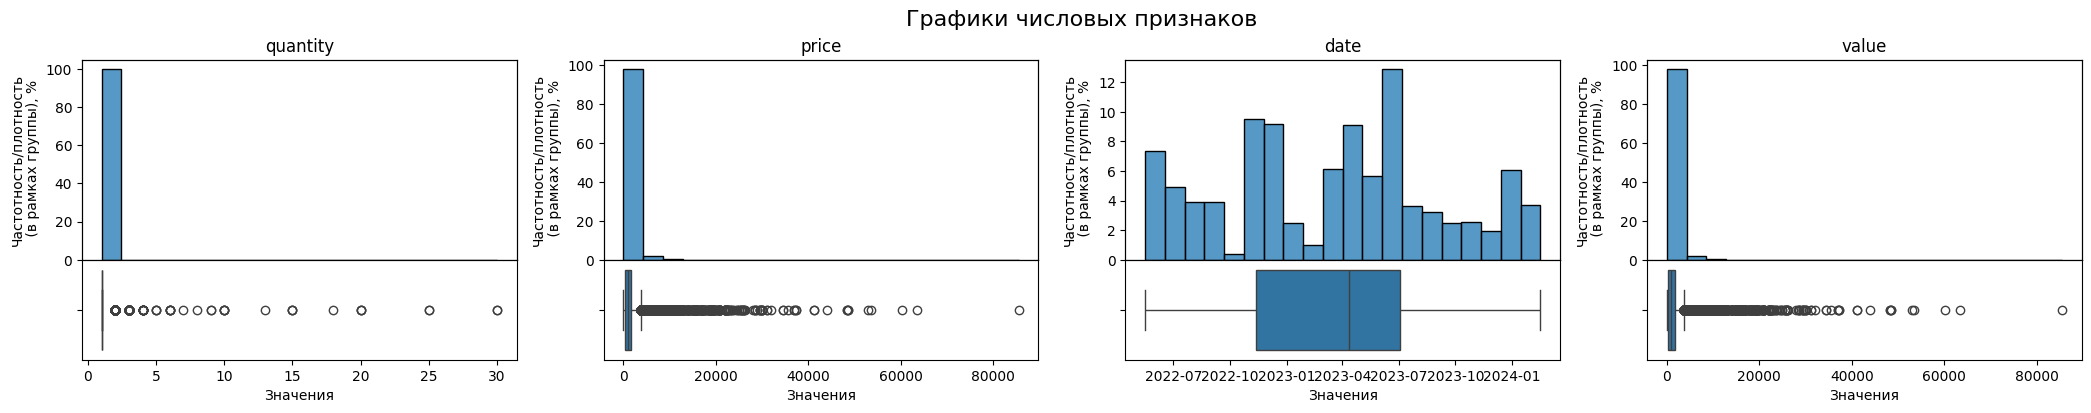

In [21]:
plot_quant_interval(
    df=purchases,
    columns=purchases.drop('client_id', axis=1) \
                     .select_dtypes(include=['number', 'datetime']).columns,
    num_cols=4,
    title='Графики числовых признаков'
)

Все признаки, кроме date, имеют крайне смещенные к нулю распределения.

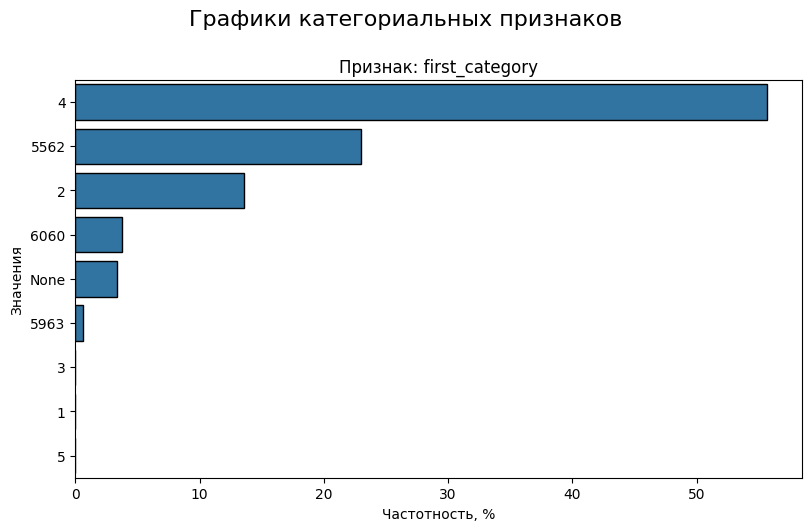

In [22]:
plot_qual(
    df=purchases,
    columns=['first_category'],
    num_cols=1,
    title='Графики категориальных признаков'
)

В категориях покупок более половины приходится на 4.

Создадим отдельные бинарные признаки для каждого значения первого кода категории для последующего агрегирования.

In [23]:
ohe = OneHotEncoder(sparse_output = False)
encoded_df = pd.DataFrame(ohe.fit_transform(purchases[['first_category']]))
encoded_df.columns = ohe.get_feature_names_out()
encoded_df = encoded_df.astype('int16')
purchases = purchases.join(encoded_df)

In [24]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,first_category,value,first_category_1,first_category_2,first_category_3,first_category_4,first_category_5,first_category_5562,first_category_5963,first_category_6060,first_category_None
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,1999.0,0,0,0,1,0,0,0,0,0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,2499.0,0,0,0,1,0,0,0,0,0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,6499.0,0,0,0,1,0,0,0,0,0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0,0,0,0,1,0,0,0,0,0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0,0,0,0,1,0,0,0,0,0


Признаки созданы.

### Данные о взаимодействиях

In [25]:
messages = df['apparel-messages'] 

In [26]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int16         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(4)
memory usage: 607.5+ MB


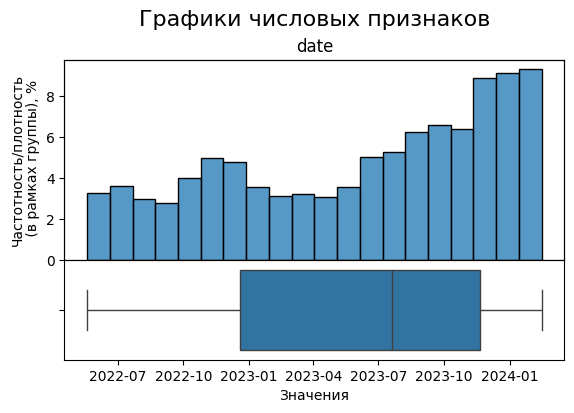

In [27]:
plot_quant_interval(
    df=messages,
    columns=['date'],
    num_cols=1,
    title='Графики числовых признаков'
)

С приближением к настоящему времени плотность дат увеличивается, т.е. растет число взаимодействий.

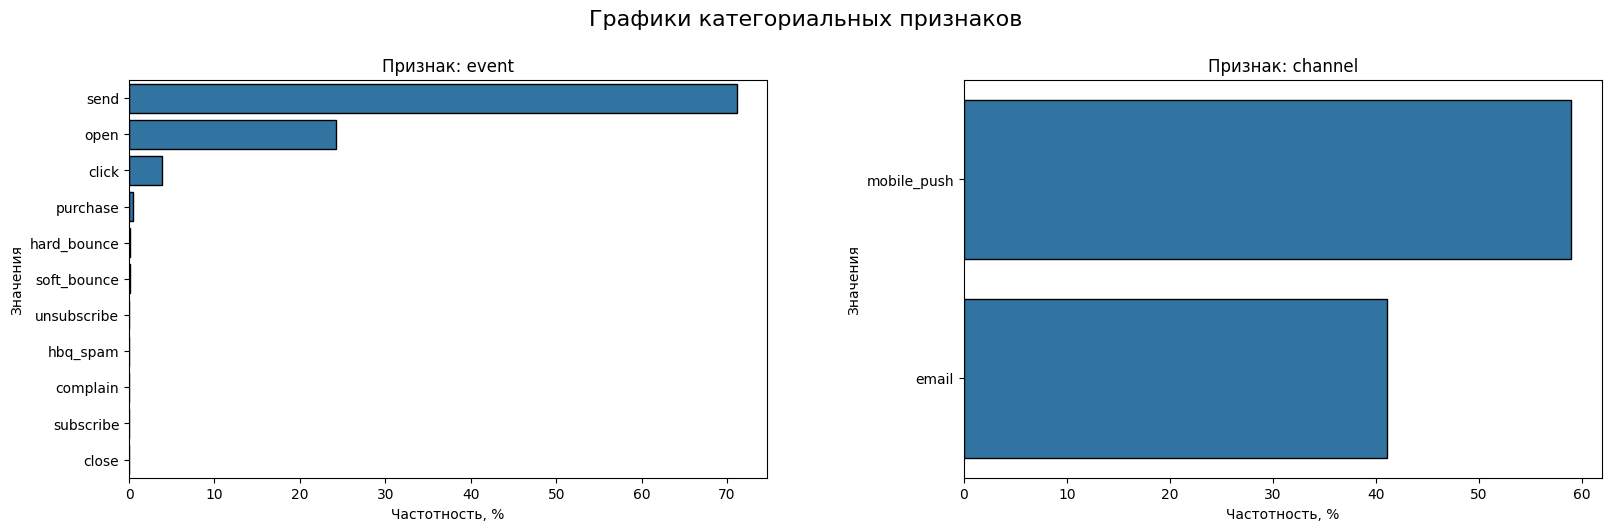

In [28]:
plot_qual(
    df=messages,
    columns=['event', 'channel'],
    num_cols=2,
    title='Графики категориальных признаков'
)

По каналам данные более-менее сбалансированы. В признаке событий наблюдается типичная "воронка": число отправленных писем больше, чем число открытых, а число открытых больше, чем число кликов. При этом "негативные" события встречаются очень редко.

Создадим отдельные бинарные признаки для признаков channel и event.

In [29]:
ohe = OneHotEncoder(sparse_output = False)
encoded_df = pd.DataFrame(ohe.fit_transform(messages[['channel', 'event']]))
encoded_df.columns = ohe.get_feature_names_out()
encoded_df = encoded_df.astype('int16')
messages = messages.join(encoded_df)

In [30]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,channel_email,channel_mobile_push,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,1,0,0,0,0,0,0,1,0,0,0,0,0
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,1,0,0,0,0,0,0,1,0,0,0,0,0
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,1,0,0,0,0,0,0,1,0,0,0,0,0
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,1,0,1,0,0,0,0,0,0,0,0,0,0
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,1,0,0,0,0,0,0,1,0,0,0,0,0


Видно несоотвествие в числах "вложенных" событий: например, число открытых писем больше числа отправленных. Исправим это расхождение.

In [31]:
messages['event_open'] = messages[['event_open','event_purchase']].max(axis=1)
messages['event_click'] = messages[['event_click','event_open']].max(axis=1)
messages['event_send'] = messages[['event_send','event_click']].max(axis=1)

### Целевой призак

In [32]:
target = df['apparel-target_binary']

Рассмотрим распределение целевого признака.

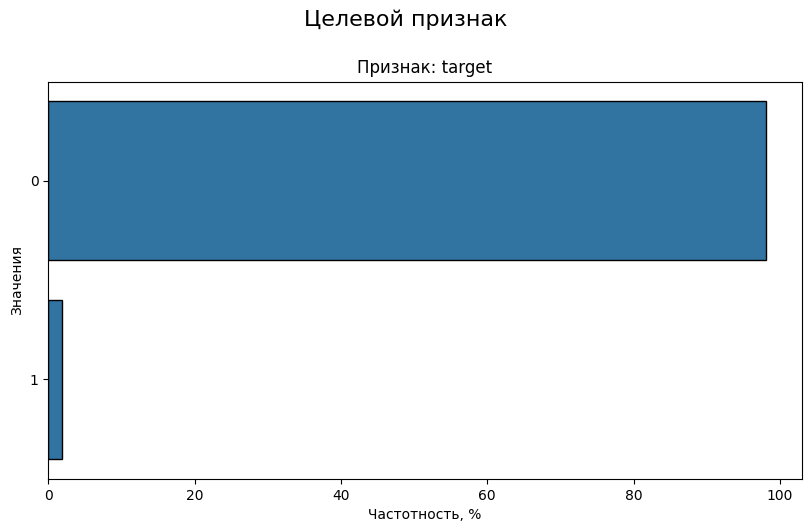

In [33]:
plot_qual(
    df=target,
    columns=['target'],
    num_cols=1,
    title='Целевой признак'
)

Данные имеют ярко выраженный дисбаланс по целевому признаку.

## Создание новых признаков

### Группировка данных о покупках

Сгруппируем полученные признаки по client_id. Используем следующие функции для агрегирования:
- для date: минимальное и максимальное значения, число, число уникальных значений, разница между максимальным и минимальным значением (т.е. как долго клиент совершает покупки);
- для quantity: сумма;
- для value: сумма.

Также рассчитаем среднюю цену как частное сумм value и quantity.

In [34]:
ohe_cols = [col for col in purchases if col.startswith('first_category_')]

d = dict.fromkeys(ohe_cols, 'sum')
d['date'] = [
    'min', 
    'max', 
    'count', 
    'nunique', 
    lambda x: (x.max() - x.min()).days + 1
]
d['quantity'] = 'sum'
d['value'] = 'sum'

purchases_grouped = purchases.groupby('client_id').agg(d)
purchases_grouped.columns = list(map('_'.join, purchases_grouped.columns.values))
purchases_grouped = purchases_grouped.rename(
    columns={'date_min': 'purchases_date_min', 
             'date_max': 'purchases_date_max',
             'date_count': 'purchases_count',
             'date_nunique': 'purchases_date_count',
             'date_<lambda_0>': 'purchases_interval'
            }
)
purchases_grouped['price_avg'] = purchases_grouped['value_sum'] / purchases_grouped['quantity_sum']

In [35]:
purchases_grouped.head()

,first_category_1_sum,first_category_2_sum,first_category_3_sum,first_category_4_sum,first_category_5_sum,first_category_5562_sum,first_category_5963_sum,first_category_6060_sum,first_category_None_sum,purchases_date_min,purchases_date_max,purchases_count,purchases_date_count,purchases_interval,quantity_sum,value_sum,price_avg
client_id,,,,,,,,,,,,,,,,,
1515915625468060902,0,0,0,7,0,0,0,0,0,2022-05-27,2022-05-27,7,1,1,7,6993.0,999.000000
1515915625468061003,0,0,0,7,0,0,0,0,0,2023-01-04,2023-01-04,7,1,1,7,16235.0,2319.285714
1515915625468061099,0,0,0,1,0,0,0,0,0,2022-05-17,2022-05-17,1,1,1,1,299.0,299.000000
1515915625468061100,0,0,0,2,0,0,0,0,0,2024-02-10,2024-02-10,2,1,1,2,2098.0,1049.000000
1515915625468061170,0,2,0,15,0,0,0,0,2,2023-03-26,2023-06-17,19,3,84,19,33601.0,1768.473684


Данные сгруппированы.

### Группировка данных о взаимодействиях

Проведем группировку по признаку client_id.

Используем следующие функции агрегации:
- для date: минимальное и максимальное значения, число, число уникальных значений;
- для бинарных признаков на основе channel и event: число.

Также рассчитаем показатели воронки продаж:
- долю открытых собщений в числе отправленных;
- долю кликов в числе открытых сообщений;
- долю покупок в числе кликов.

In [36]:
d = {}
d['date'] = [
    'min', 
    'max', 
    'count', 
    'nunique'
]
d['channel_email'] = 'sum'
d['channel_mobile_push'] = 'sum'
d['event_send'] = 'sum'
d['event_open'] = 'sum'
d['event_click'] = 'sum'
d['event_purchase'] = 'sum'
d['event_complain'] = 'sum'
d['event_hard_bounce'] = 'sum'
d['event_soft_bounce'] = 'sum'
d['event_subscribe'] = 'sum'
d['event_unsubscribe'] = 'sum'

messages_grouped = messages.groupby('client_id').agg(d)
messages_grouped.columns = list(map('_'.join, messages_grouped.columns.values))
messages_grouped = messages_grouped.rename(
    columns={'date_min': 'messages_date_min', 
             'date_max': 'messages_date_max',
             'date_count': 'messages_count', 
             'date_nunique': 'messages_date_count'
            }
)

messages_grouped['open_to_send'] = messages_grouped['event_open_sum'] / messages_grouped['event_send_sum'].clip(1)
messages_grouped['click_to_open'] = messages_grouped['event_click_sum'] / messages_grouped['event_open_sum'].clip(1)
messages_grouped['purchase_to_click'] = messages_grouped['event_purchase_sum'] / messages_grouped['event_click_sum'].clip(1)
messages_grouped['purchase_to_send'] = messages_grouped['event_purchase_sum'] / messages_grouped['event_send_sum'].clip(1)

In [37]:
messages_grouped.head()

,messages_date_min,messages_date_max,messages_count,messages_date_count,channel_email_sum,channel_mobile_push_sum,event_send_sum,event_open_sum,event_click_sum,event_purchase_sum,event_complain_sum,event_hard_bounce_sum,event_soft_bounce_sum,event_subscribe_sum,event_unsubscribe_sum,open_to_send,click_to_open,purchase_to_click,purchase_to_send
client_id,,,,,,,,,,,,,,,,,,,
1515915625468060902,2022-05-19,2024-01-19,177,136,177,0,176,40,50,5,0,0,0,0,1,0.227273,1.250000,0.100000,0.028409
1515915625468061003,2022-05-20,2024-02-13,166,155,166,0,166,6,12,1,0,0,0,0,0,0.036145,2.000000,0.083333,0.006024
1515915625468061099,2022-05-19,2024-02-13,276,191,182,94,274,51,59,0,0,2,0,0,0,0.186131,1.156863,0.000000,0.000000
1515915625468061100,2022-05-19,2024-02-15,434,228,0,434,432,164,165,1,0,1,1,0,0,0.379630,1.006098,0.006061,0.002315
1515915625468061170,2022-05-25,2024-02-15,293,212,202,91,293,34,50,3,0,0,0,0,0,0.116041,1.470588,0.060000,0.010239


Данные сгруппированы.

### Объединение датафреймов

Присоединим сгруппированные датафреймы с покупками и взаимодействиями к датафрейму с целевыми значениями.

In [38]:
data = target.merge(purchases_grouped, how='left', on='client_id') \
             .merge(messages_grouped, how='left', on='client_id')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   client_id                49849 non-null  int64         
 1   target                   49849 non-null  int8          
 2   first_category_1_sum     49849 non-null  int16         
 3   first_category_2_sum     49849 non-null  int16         
 4   first_category_3_sum     49849 non-null  int16         
 5   first_category_4_sum     49849 non-null  int16         
 6   first_category_5_sum     49849 non-null  int16         
 7   first_category_5562_sum  49849 non-null  int16         
 8   first_category_5963_sum  49849 non-null  int16         
 9   first_category_6060_sum  49849 non-null  int16         
 10  first_category_None_sum  49849 non-null  int16         
 11  purchases_date_min       49849 non-null  datetime64[ns]
 12  purchases_date_max       49849 n

Заполним пропуски в признаках на основе данных о взаимодейсвиях (кроме дат) нулями.

In [40]:
data[data.select_dtypes(include='float64').columns] = data[data.select_dtypes(include='float64').columns] \
                                                      .fillna(0)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   client_id                49849 non-null  int64         
 1   target                   49849 non-null  int8          
 2   first_category_1_sum     49849 non-null  int16         
 3   first_category_2_sum     49849 non-null  int16         
 4   first_category_3_sum     49849 non-null  int16         
 5   first_category_4_sum     49849 non-null  int16         
 6   first_category_5_sum     49849 non-null  int16         
 7   first_category_5562_sum  49849 non-null  int16         
 8   first_category_5963_sum  49849 non-null  int16         
 9   first_category_6060_sum  49849 non-null  int16         
 10  first_category_None_sum  49849 non-null  int16         
 11  purchases_date_min       49849 non-null  datetime64[ns]
 12  purchases_date_max       49849 n

Построим графики для числовых признаков.

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


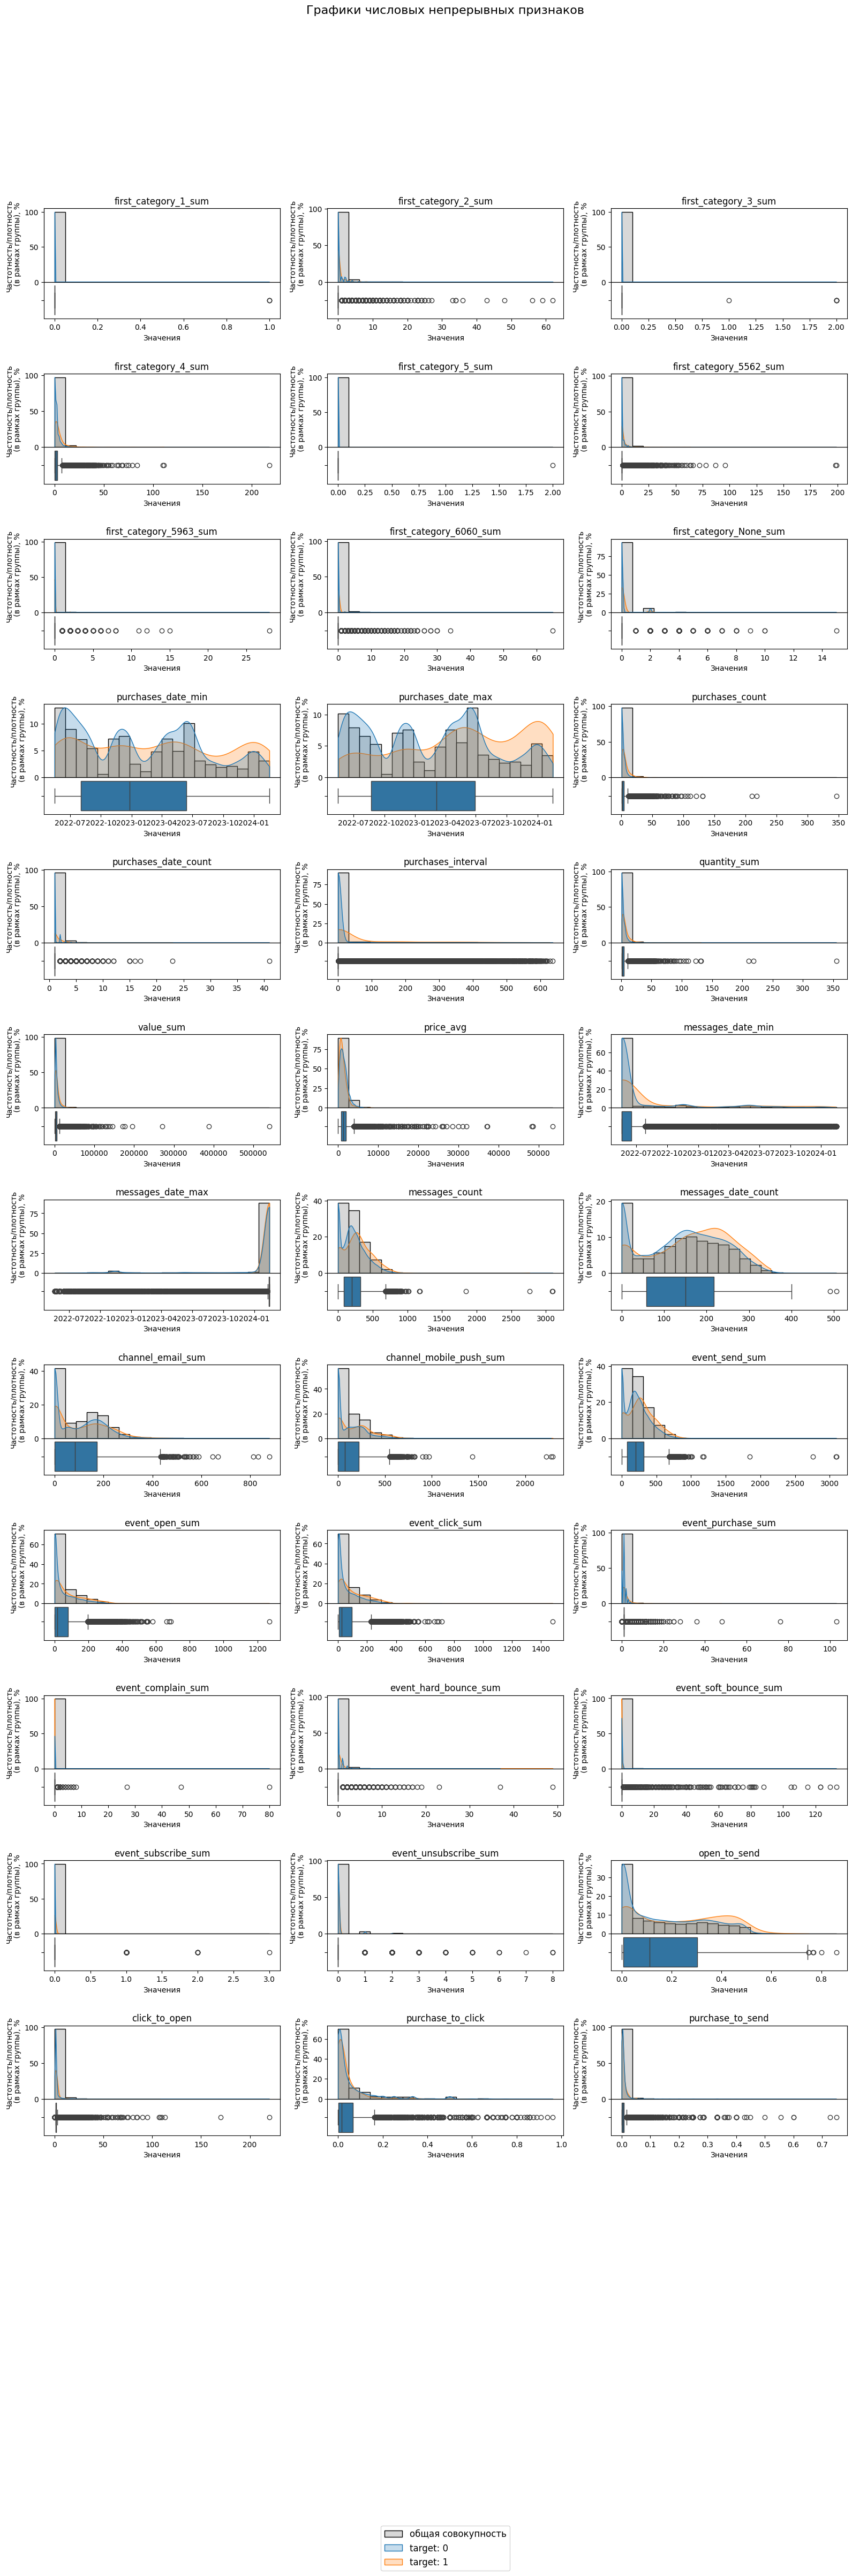

In [42]:
plot_quant_interval(
    df=data,
    columns=data.drop(['client_id','target'], axis=1).columns,
    num_cols=3,
    title='Графики числовых непрерывных признаков',
    hue='target'
)

Мы видим различия распределений признаков в зависимости от целевого признака: first_category_4_sum, purchases_date_min, purchases_date_max, purchases_interval, messages_date_min, messages_date_count, open_to_send.

### Матрица корреляции

In [43]:
data['purchases_date_min'] = data['purchases_date_min'].astype(int)//1e9
data['purchases_date_max'] = data['purchases_date_max'].astype(int)//1e9
data['messages_date_min'] = data['messages_date_min'].astype(int)//1e9
data['messages_date_max'] = data['messages_date_max'].astype(int)//1e9

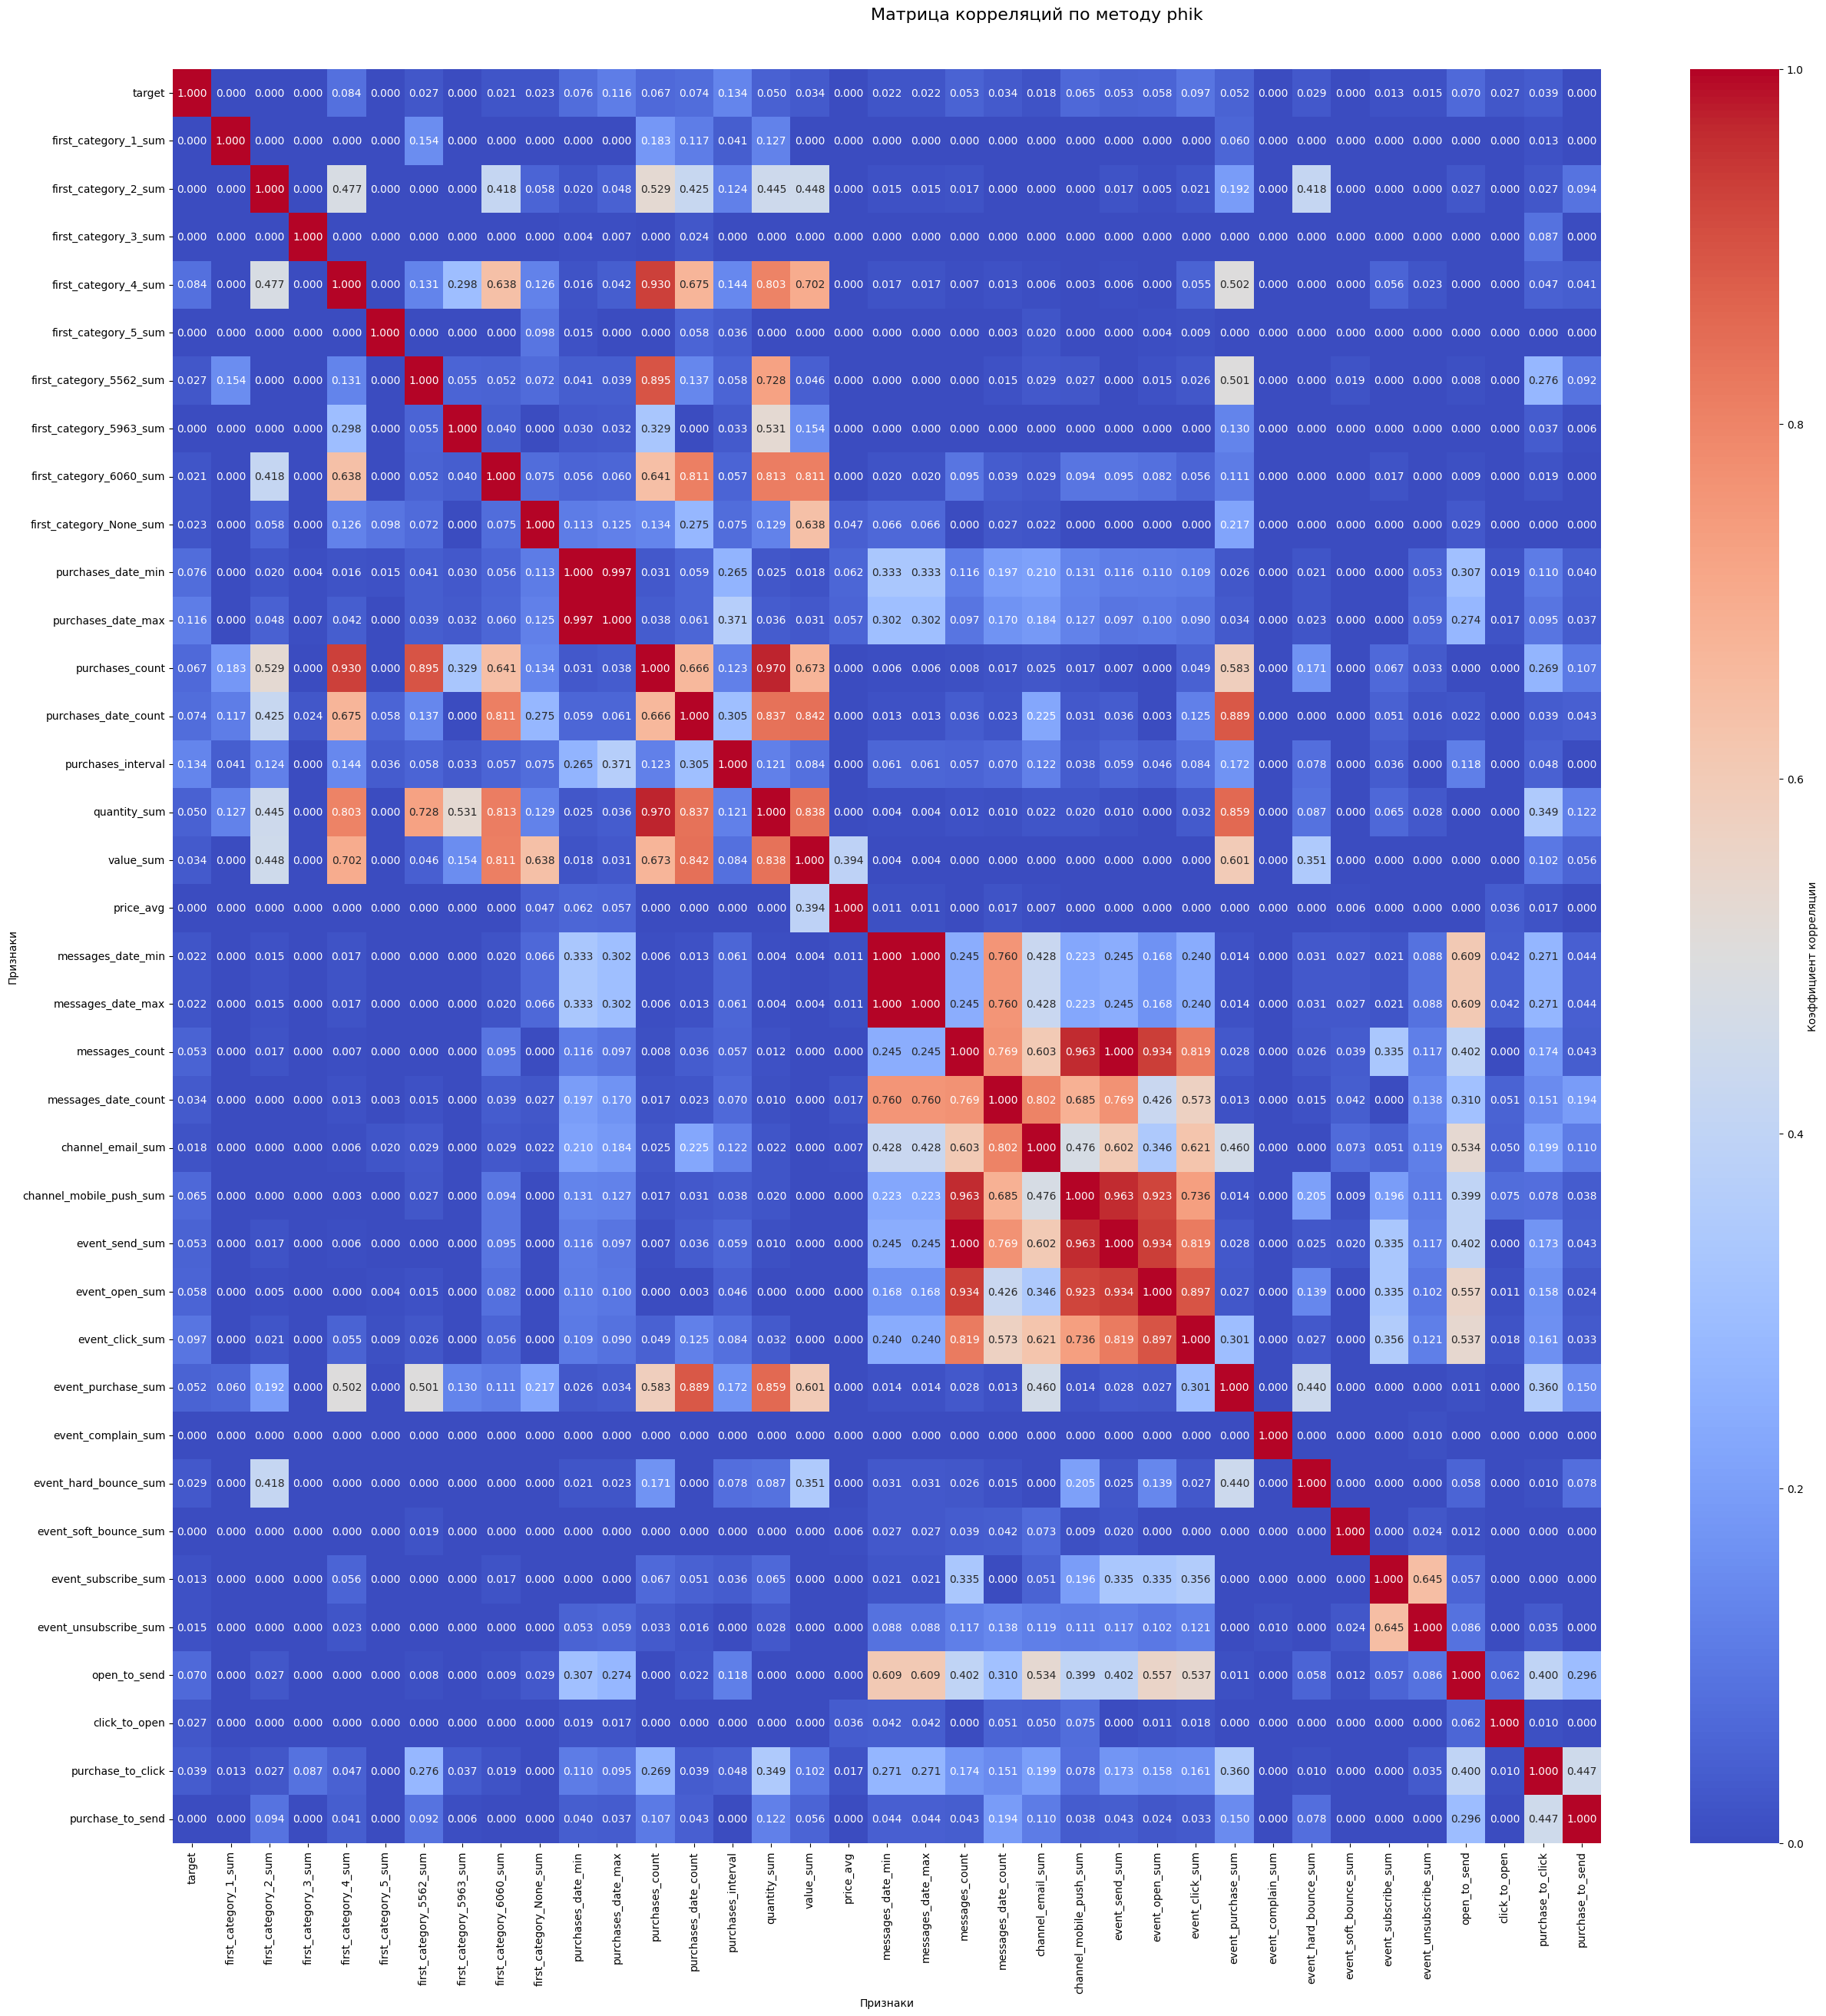

In [44]:
plt.figure(figsize=(30, 30))
sns.heatmap(
    data.drop('client_id', axis=1).phik_matrix(
        interval_cols = data.drop(['client_id', 'target'], axis=1).columns
    ),
    annot=True, fmt='.3f', cmap='coolwarm'
);
fig, ax = plt.gcf(), plt.gca()
fig.suptitle('Матрица корреляций по методу phik', va='bottom', y=0.9, fontsize=16)
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
cb_ax = fig.axes[1]
cb_ax.set_ylabel('Коэффициент корреляции')
plt.show()

Наибольшие коэффициенты корреляции с целевым признаком имеют:
- purchases_interval;
- purchases_date_max;
- event_click_sum;
- first_category_4_sum;
- purchases_date_min;
- purchases_date_count.

То есть основное влияние оказывают признаки, связанные с датами покупок.

## Построение моделей

### Разделение выборок

Поскольку наблюдается дисбаланс по целевому признаку, при разделении на выборки используем стратификацию.

In [45]:
data_ = data.copy()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    data_.drop(['target', 'client_id'], axis=1), 
    data_['target'], 
    test_size=0.25, 
    random_state=RANDOM_STATE,
    stratify=data_['target']
)

### Перебор моделей

Рассмотрим модели:
- DecisionTreeClassifier;
- RandomForestClassifier;
- LGBMClassifier;
- CatBoostClassifier.

In [47]:
pipe = Pipeline([
    ('models', 
      DecisionTreeClassifier(
          random_state=RANDOM_STATE
      )
    )
])

param_grid = [
    {
        'models': 
        [
            DecisionTreeClassifier(
                random_state=RANDOM_STATE
            )
        ]
    }, 
    {
        'models': 
        [
            RandomForestClassifier(
                random_state=RANDOM_STATE
            )
        ]
    }, 
    {
        'models': 
        [
            LGBMClassifier(
                eval_metric='auc',
                random_state=RANDOM_STATE,
                verbose=-1
            )
        ]
    }, 
    {
        'models': 
        [
            CatBoostClassifier(
                eval_metric='AUC',
                random_seed=RANDOM_STATE,
                verbose=False
            )
        ]
    }
]

In [48]:
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

In [49]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(random_state=42)]},
                         {'models': [RandomForestClassifier(random_state=42)]},
                         {'models': [LGBMClassifier(eval_metric='auc',
                                                    random_state=42,
                                                    verbose=-1)]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x790068189de0>]}],
             scoring='roc_auc')

In [50]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.638708,0.039634,0.024319,0.000672,DecisionTreeClassifier(random_state=42),{'models': DecisionTreeClassifier(random_state...,0.517168,0.519645,0.518406,0.001238,4
1,8.101142,0.448250,0.965851,0.240091,RandomForestClassifier(random_state=42),{'models': RandomForestClassifier(random_state...,0.692630,0.684188,0.688409,0.004221,3
2,1.721940,0.196748,0.300476,0.007330,"LGBMClassifier(eval_metric='auc', random_state...","{'models': LGBMClassifier(eval_metric='auc', r...",0.681534,0.717103,0.699319,0.017785,2
3,19.254885,0.076929,0.061522,0.008310,<catboost.core.CatBoostClassifier object at 0x...,{'models': <catboost.core.CatBoostClassifier o...,0.717567,0.730834,0.724200,0.006633,1


Лучшие показатели на кросс-валидации показали LightGBM и CatBoost. Обучим их на всей тренировочной выборке и построим графики ROC на тестовых данных.

In [51]:
lgbm = LGBMClassifier(
    eval_metric='auc',
    random_state=RANDOM_STATE,
    verbose=-1
)
cat = CatBoostClassifier(
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=False
)

In [52]:
df_models = pd.DataFrame(columns=['model', 'fpr','tpr','thresholds', 'auc'])
df_models = df_models.set_index('model')

for model in [lgbm, cat]:
    model.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    print(f'{model.__class__.__name__}: ROC AUC = {auc:.3f}')
    df_models.loc[model.__class__.__name__] = fpr, tpr, thresholds, auc

LGBMClassifier: ROC AUC = 0.728
CatBoostClassifier: ROC AUC = 0.733


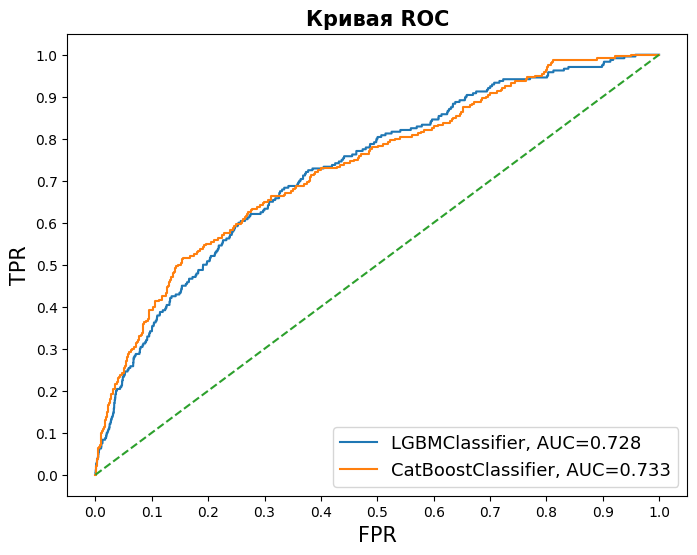

In [53]:
fig = plt.figure(figsize=(8,6))

for i in df_models.index:
    plt.plot(df_models.loc[i]['fpr'], 
             df_models.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, df_models.loc[i]['auc']))

plt.plot([0,1], [0,1], linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("FPR", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("TPR", fontsize=15)

plt.title('Кривая ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

По метрике ROC AUC лучшей моделью является модель на основе CatBoost. Однако на некоторых интервалах порогов лучше соотношение TPR и FPR показывает модель на основе LightGBM. Устроим для этих моделей "соревнование" с подбором гиперпараметров.

### Подбор гиперпараметров

#### LightGBM

In [54]:
def objective(trial):
   
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 100), 
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    model = LGBMClassifier(
                **params, 
                eval_metric='auc',
                random_state=RANDOM_STATE,
                verbose=-1
            )
    
    model.fit(
        X_train, 
        y_train
    )

    trial.set_user_attr(key='best_model', value=model)
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_pred)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])


sampler = TPESampler(seed=RANDOM_STATE)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(objective, timeout=60, callbacks=[callback])

[I 2024-12-01 19:04:39,108] A new study created in memory with name: no-name-9808ecc1-db14-47df-aeca-9d13b0b42c70
[I 2024-12-01 19:04:40,173] Trial 0 finished with value: 0.7319781354822874 and parameters: {'num_leaves': 44, 'max_depth': 10}. Best is trial 0 with value: 0.7319781354822874.
[I 2024-12-01 19:04:41,232] Trial 1 finished with value: 0.7100096471133654 and parameters: {'num_leaves': 76, 'max_depth': 7}. Best is trial 0 with value: 0.7319781354822874.
[I 2024-12-01 19:04:41,946] Trial 2 finished with value: 0.7476691824156645 and parameters: {'num_leaves': 24, 'max_depth': 4}. Best is trial 2 with value: 0.7476691824156645.
[I 2024-12-01 19:04:42,694] Trial 3 finished with value: 0.7431421977692328 and parameters: {'num_leaves': 15, 'max_depth': 9}. Best is trial 2 with value: 0.7476691824156645.
[I 2024-12-01 19:04:43,827] Trial 4 finished with value: 0.7106121655894625 and parameters: {'num_leaves': 64, 'max_depth': 8}. Best is trial 2 with value: 0.7476691824156645.
[I 20

In [55]:
lgbm_tuned = study.user_attrs['best_model']

In [56]:
roc_auc_score(y_test, lgbm_tuned.predict_proba(X_test)[:,1])

0.7525196692028688

#### CatBoost

In [57]:
def objective(trial):
   
    params = {
        'depth': trial.suggest_int('depth', 2, 7),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 4),
        
    }

    model = CatBoostClassifier(
                **params, 
                eval_metric='AUC',
                random_seed=RANDOM_STATE,
                verbose=False
            )
    
    model.fit(
        X_train, 
        y_train
    )

    trial.set_user_attr(key='best_model', value=model)
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_pred)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])


sampler = TPESampler(seed=RANDOM_STATE)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(objective, timeout=60, callbacks=[callback])

[I 2024-12-01 19:05:39,543] A new study created in memory with name: no-name-6ce61035-3475-4348-a009-7258d534a6fa
[I 2024-12-01 19:05:47,269] Trial 0 finished with value: 0.7564652703918843 and parameters: {'depth': 4, 'l2_leaf_reg': 3.9014286128198323}. Best is trial 0 with value: 0.7564652703918843.
[I 2024-12-01 19:05:58,017] Trial 1 finished with value: 0.7468958793531322 and parameters: {'depth': 6, 'l2_leaf_reg': 3.197316968394073}. Best is trial 0 with value: 0.7564652703918843.
[I 2024-12-01 19:06:03,981] Trial 2 finished with value: 0.7524427990946031 and parameters: {'depth': 2, 'l2_leaf_reg': 2.3119890406724055}. Best is trial 0 with value: 0.7564652703918843.
[I 2024-12-01 19:06:10,589] Trial 3 finished with value: 0.7506568900160899 and parameters: {'depth': 2, 'l2_leaf_reg': 3.73235229154987}. Best is trial 0 with value: 0.7564652703918843.
[I 2024-12-01 19:06:19,606] Trial 4 finished with value: 0.7525225667457526 and parameters: {'depth': 5, 'l2_leaf_reg': 3.41614515559

In [58]:
cat_tuned = study.user_attrs['best_model']

In [59]:
roc_auc_score(y_test, cat_tuned.predict_proba(X_test)[:,1])

0.7564652703918843

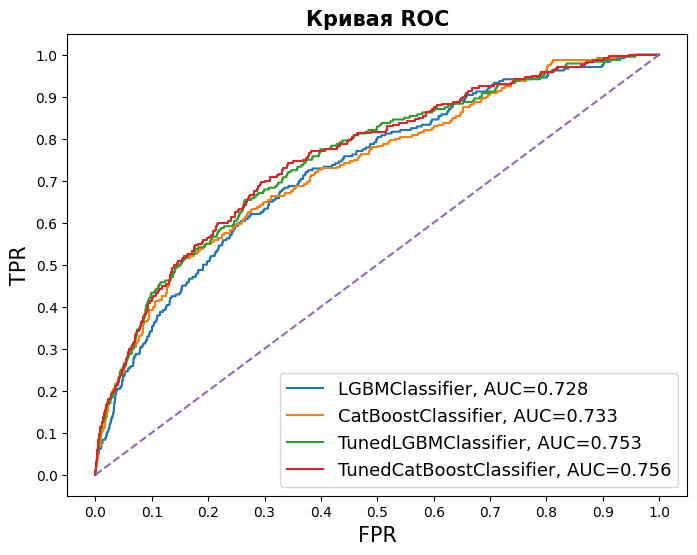

In [60]:
for model in [lgbm_tuned, cat_tuned]:
    yproba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    df_models.loc[f'Tuned{model.__class__.__name__}'] = fpr, tpr, thresholds, auc

fig = plt.figure(figsize=(8,6))

for i in df_models.index:
    plt.plot(df_models.loc[i]['fpr'], 
             df_models.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, df_models.loc[i]['auc']))

plt.plot([0,1], [0,1], linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("FPR", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("TPR", fontsize=15)

plt.title('Кривая ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Чуть более лучший результат показал CatBoost.

### Анализ результатов моделирования 

Построим confusion matrix для лучшей модели.

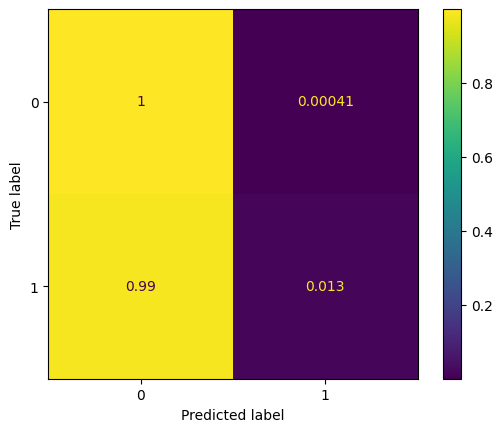

In [61]:
y_pred = cat_tuned.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize='true'
);

Модель хорошо распознает класс 0 (но у него и значительно больше доля) и практически не распознает класс 1. Вместе с тем класс 1 может быть важен для заказчика, т.к. это потенциальные постоянные / лояльные клиенты.

Для оценки точности распознавания класса 1 рассчитаем метрику F1. 

In [62]:
print(f'Метрика F1: {f1_score(y_test, y_pred):.2f}')

Метрика F1: 0.02


Метрика очень низкая. Попробуем ее улучшить на той же модели. Для этого вычислим оптимальное пороговое значение исходя из принципа максимальной удаленности точки от линии TPR = FPR.

In [63]:
J = df_models.loc['TunedCatBoostClassifier']['tpr'] - df_models.loc['TunedCatBoostClassifier']['fpr']
ix = np.argmax(J)
best_thresh = df_models.loc['TunedCatBoostClassifier']['thresholds'][ix]
print(f'Оптимальное пороговое значение {best_thresh:.4f}')

Оптимальное пороговое значение 0.0173


In [64]:
cat_tuned.set_probability_threshold(best_thresh)

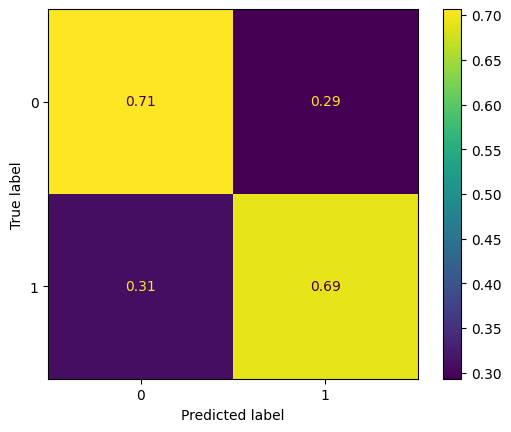

In [65]:
y_pred = cat_tuned.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize='true'
);

Теперь модель распознает более 2/3 объектов класса 1. Правда, и доля распознаваемых объектов класса 0 уменьшилась до 71%.

In [66]:
print(f'Метрика F1: {f1_score(y_test, y_pred):.2f}')

Метрика F1: 0.08


Метрика улучшилась.

## Анализ важности признаков

Построим график shap для лучшей модели.

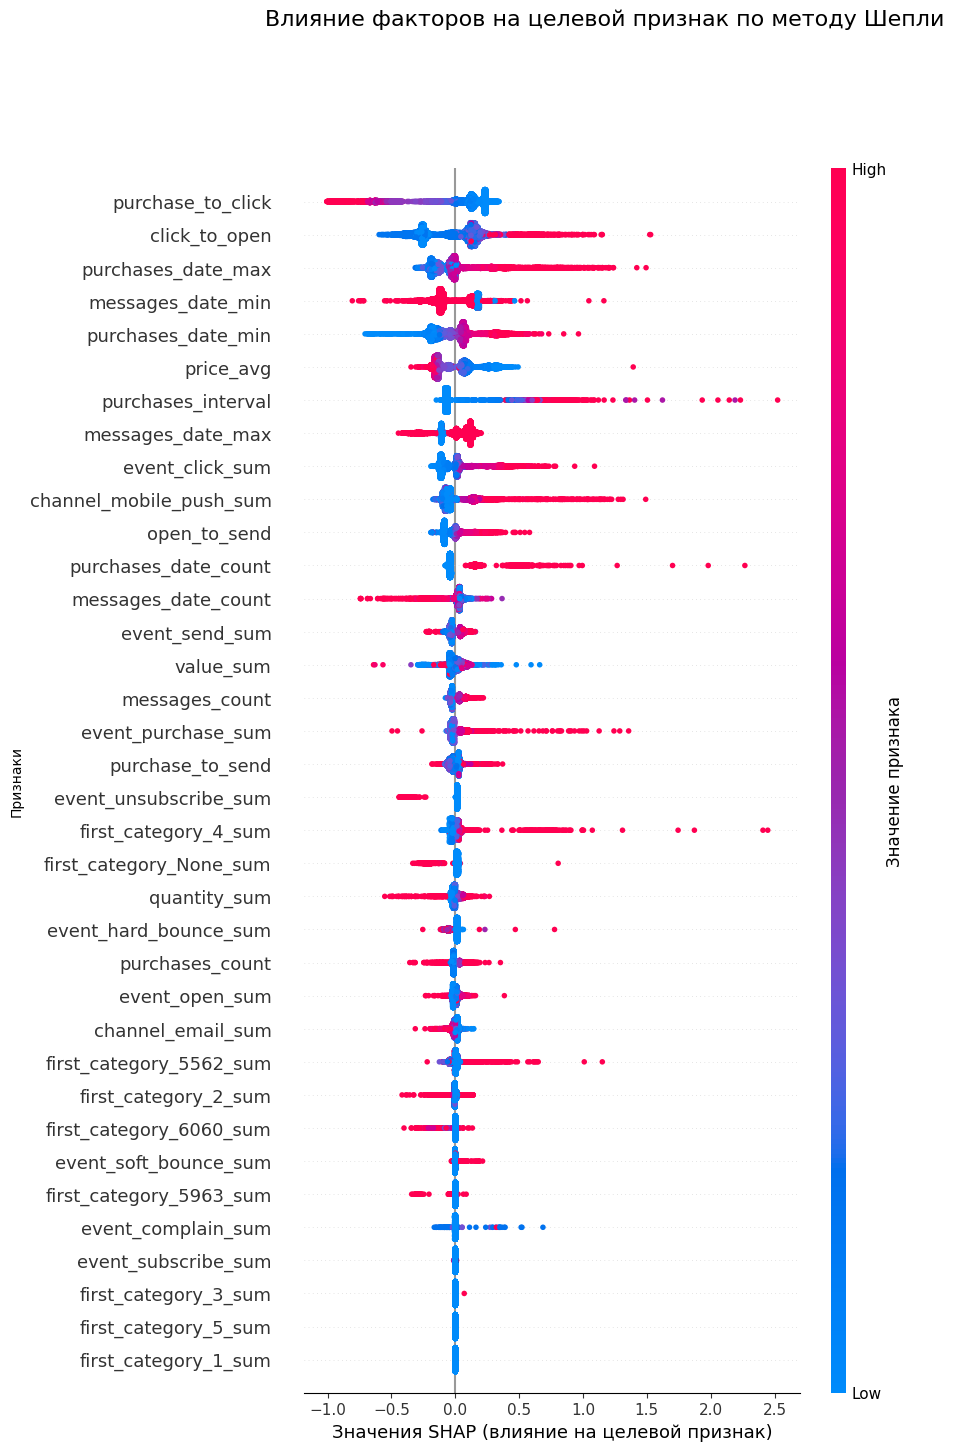

In [67]:
explainer = shap.TreeExplainer(cat_tuned)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=40, show=False)

fig, ax = plt.gcf(), plt.gca()
fig.suptitle('Влияние факторов на целевой признак по методу Шепли', fontsize=16)
ax.set_xlabel('Значения SHAP (влияние на целевой признак)')
ax.set_ylabel('Признаки')
cb_ax = fig.axes[1]
cb_ax.set_ylabel('Значение признака')
plt.show()

На результаты модели наибольшее влияние оказывают следующие признаки:
- отношение числа покупок к числу кликов (обратное влияние: если человек уже совершил покупку в результате взаимодействия, то вряд ли он в ближайее время совершит ее снова);
- отношение числа кликов к числу открытых писем (прямое влияние: если человек еще не купил товар, то, вероятно, он сделает это в ближайшее время);
- дата предыдущей покупки (прямое влияние: если человек покупал что-то недавно, он, вероятно, скоро еще раз вернется);
- дата первого взаимодействия (влияние разнонаправленное, но чем раньше было это взаимодействие, тем вероятнее, что человек совершит покупку);
- дата первой покукпи (прямое влияние: если человек недавно совершил первую покупку, то, вероятно, он сделает покупку снова);
- средняя цена (обратное влияние: чем выше средняя цена покупки, тем менее вероятно, что в ближайшее время человек совершит новую - возможно, здесь имеет место покупка дорогостоящих товаров длительного пользования, которые приобретаются нечасто).

## Результаты и выводы

Мы проанализировали данные заказчика и построили модель для предсказания вероятностя покупки в течение 90 дней.

В том числе:
1. Проведена загрузка и предобработка данных, в т.ч. обработан столбец category_ids и объединены датафреймы с данными о покупках и взаимодействиях.
2. Исследовательский анализ показал, что наибольшее влияние на целевой признак имеют признаки, связанные с датами покупок. Также установлен значительный дисбаланс по целевому признаку.
3. В качестве синтетических признаков использованы различные агрегирующие показатели: 
- сумма числа покупок в зависимости от основной (первой) категории;
- минимальные и макисмальные даты покупки и взаимодействия;
- интервалы покупок и взаимодействия (разница между максимальным и минимальным значением);
- число и сумма покупок;
- число взаимодействий.
4. Построены различные модели прогнозирования совершения покупки:
- простое дерево решений;
- случайный лес;
- LightGBM;
- CatBoost.
5. Лучший результат на тестовой выборке показали модели LightGBM с ROC AUC = 0.728 и CatBoost с ROC AUC = 0.733.
6. Проведен подбор гиперпараметров для данных моделей. В итоге лучший результат показала модель CatBoost с ROC AUC = 0.756.
7. Анализ результатов лучшей модели показал, что с порогом по умолчанию модель практически не может верно определить класс 1: метрика F1 составила 0.02. В связи с этим была проведена корректировка порога, после чего метрика F1 увеличилась до 0.08.
8. Анализ важности признаков показал, что на результаты модели наибольшее влияние оказывают следующие признаки:
- отношение числа покупок к числу кликов (обратное влияние);
- отношение числа кликов к числу открытых писем (прямое влияние);
- дата предыдущей покупки (прямое влияние);
- дата первого взаимодействия (обратное влияние для старых дат);
- дата первой покукпи (прямое влияние);
- средняя цена (обратное влияние).

Рекомендация заказчику: уточнить целевую метрику. Действительно ли для заказчика важна именно ROC AUC, которая плохо интерпретируется в бизнес-логике?